In [1]:
import os
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
import sys
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Add necessary paths for custom modules
sys.path.append("/share/u/wendler/code/my-sdxl-unbox")

from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from utils import add_feature_on_area_turbo

import supervision as sv
import pycocotools.mask as mask_util
from torchvision.ops import box_convert

# Grounded SAM2 and Grounding DINO imports
sys.path.append("/share/u/wendler/code/Grounded-SAM-2")
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, predict
import grounding_dino.groundingdino.datasets.transforms as T


In [2]:
import open_clip
class CLIPScorer:
    def __init__(self, model_name='ViT-L-14'):
        self.model_name = model_name
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(model_name, pretrained='openai')
        self.model.cuda()
        self.model.eval()
        self.tokenizer = open_clip.get_tokenizer(model_name)

    def embed_texts(self, texts):
        with torch.no_grad(), torch.cuda.amp.autocast():
            text = self.tokenizer(texts).cuda()
            text_features = self.model.encode_text(text)
        return text_features

    def embed_images(self, images):
        with torch.no_grad(), torch.cuda.amp.autocast():
            tensors = []
            for img in images:
                if isinstance(img, np.ndarray):
                    img = Image.fromarray(img)
                tensor = self.preprocess(img).unsqueeze(0)
                tensors += [tensor]
            tensors = torch.cat(tensors, dim=0)
            image_features = self.model.encode_image(tensors.cuda())
        return image_features

    def get_scores(self, texts, images, normalize=True):
        text_features = self.embed_texts(texts)
        image_features = self.embed_images(images)
        if normalize:
            text_features /= text_features.norm(dim=-1, keepdim=True)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (text_features @ image_features.T)
        return scores

    def get_scores_images(self, images1, images2, normalize=True):
        image_features1 = self.embed_images(images1)
        image_features2 = self.embed_images(images2)
        if normalize:
            image_features1 /= image_features1.norm(dim=-1, keepdim=True)
            image_features2 /= image_features2.norm(dim=-1, keepdim=True)
        scores = (image_features1 @ image_features2.T)
        return scores

In [32]:
from torch import rand
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import PIL
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')
def img2lpips(img): # resulve this RuntimeError: Could not infer dtype of PngImageFile
    if isinstance(img, PIL.Image.Image):
        # this is what i tried to do    
        img = np.array(img)
        return (torch.tensor(img).float()/255.).unsqueeze(0).permute(0, 3, 1, 2)
    if isinstance(img, np.ndarray) and img.dtype == np.uint8:
        return (torch.tensor(img).float()/255.).unsqueeze(0).permute(0, 3, 1, 2)
    else:
        return img
# LPIPS needs the images to be in the [-1, 1] range.
img1 = (rand(10, 3, 100, 100) * 2) - 1
img2 = (rand(10, 3, 100, 100) * 2) - 1
print(lpips(img1, img2))
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex', normalize=True)
#print(lpips(img2lpips(IMAGES[0]), img2lpips(IMAGES[1])))

tensor(0.1490)


In [4]:
ref_path = "/share/u/wendler/code/Grounded-SAM-2/results/PIE-Bench-final/reference"
# pre load all of the reference images
ref_images = {}
import os
import glob
from PIL import Image

# Process subfolders 1-9
for i in range(1, 10):
    subfolder_path = os.path.join(ref_path, str(i))
    if os.path.exists(subfolder_path):
        for ref in glob.glob(os.path.join(subfolder_path, "*_img1.png")):
            base_name = os.path.basename(ref).replace("_img1.png", "")
            img1_path = ref
            img2_path = ref.replace("_img1.png", "_img2.png")
            #print(img1_path, img2_path)
            if os.path.exists(img2_path):
                ref_images[f"{i}/{base_name}_img1"] = Image.open(img1_path)
                ref_images[f"{i}/{base_name}_img2"] = Image.open(img2_path)

In [23]:
img2lpips(img1)

PIL.PngImagePlugin.PngImageFile

In [35]:
# get 2 images and try lpips
img1 = ref_images[f"{i}/{base_name}_img1"]
img2 = ref_images[f"{i}/{base_name}_img2"]
print(lpips(img2lpips(img1), img2lpips(img2)))


tensor(0.6596)


In [69]:
import glob

name_path = {}
for sae in glob.glob("/share/u/wendler/code/Grounded-SAM-2/results/PIE-Bench-final/modesae*"):
    name = sae.split("/")[-1]
    ktrans = int(name.split("ktrans")[1].split("_")[0])
    strength = float(name.split("_str")[1])
    name_path[f"sae_{ktrans}_{strength}"] = sae

for steering in glob.glob("/share/u/wendler/code/Grounded-SAM-2/results/PIE-Bench-final/modesteering*"):
    name = steering.split("/")[-1]
    strength = float(name.split("_str")[1])
    name_path[f"steer_{strength}"] = steering

for neurons in glob.glob("/share/u/wendler/code/Grounded-SAM-2/results/PIE-Bench-final/modeneurons*"):
    name = neurons.split("/")[-1]
    ktrans = int(name.split("ktrans")[1].split("_")[0])
    strength = float(name.split("_str")[1])
    name_path[f"neur_{ktrans}_{strength}"] = neurons

In [6]:
clip_scorer = CLIPScorer()

In [45]:
list(ref_images.keys())

['1/111000000000_img1',
 '1/111000000000_img2',
 '1/111000000001_img1',
 '1/111000000001_img2',
 '1/111000000002_img1',
 '1/111000000002_img2',
 '1/111000000003_img1',
 '1/111000000003_img2',
 '1/111000000004_img1',
 '1/111000000004_img2',
 '1/111000000005_img1',
 '1/111000000005_img2',
 '1/111000000006_img1',
 '1/111000000006_img2',
 '1/111000000007_img1',
 '1/111000000007_img2',
 '1/111000000008_img1',
 '1/111000000008_img2',
 '1/111000000009_img1',
 '1/111000000009_img2',
 '1/112000000000_img1',
 '1/112000000000_img2',
 '2/211000000000_img1',
 '2/211000000000_img2',
 '2/211000000001_img1',
 '2/211000000001_img2',
 '2/211000000002_img1',
 '2/211000000002_img2',
 '2/211000000003_img1',
 '2/211000000003_img2',
 '2/211000000004_img1',
 '2/211000000004_img2',
 '2/211000000005_img1',
 '2/211000000005_img2',
 '2/211000000006_img1',
 '2/211000000006_img2',
 '2/211000000007_img1',
 '2/211000000007_img2',
 '2/211000000008_img1',
 '2/211000000008_img2',
 '2/211000000009_img1',
 '2/211000000009

In [65]:
from collections import defaultdict
import pandas as pd

def score_path(name, path, ref_images, n_imgs = None):
    scores = defaultdict(list)
    # iterate over all images and calculate the score folder structure is agian 1/... 2/... etc
    cnt = 0
    for i in range(1, 10):
        subfolder_path = os.path.join(path, str(i))
        if os.path.exists(subfolder_path):
            for img in glob.glob(os.path.join(subfolder_path, "*.png")):
                # select the image that does not contain _ in its name
                if "_" not in os.path.basename(img):
                    try:
                        intervention_image = Image.open(img)
                        # get the base name
                        base_name = os.path.basename(img).replace(".png", "")
                        print("processing", base_name,"...")
                        # get the reference images
                        ref_image1 = ref_images[f"{i}/{base_name}_img1"] # edited prompt
                        ref_image2 = ref_images[f"{i}/{base_name}_img2"] # original prompt
                        # calculate the score
                        lpips_original = lpips(img2lpips(intervention_image), img2lpips(ref_image2))
                        lpips_edited = lpips(img2lpips(intervention_image), img2lpips(ref_image1))
                        # Convert PIL PngImageFile to jpg format in memory
                        intervention_jpg = intervention_image.convert('RGB')
                        ref_image1_jpg = ref_image1.convert('RGB')
                        ref_image2_jpg = ref_image2.convert('RGB')
                        
                        clip_img_original = clip_scorer.get_scores_images([intervention_jpg], [ref_image2_jpg])
                        clip_img_edited = clip_scorer.get_scores_images([intervention_jpg], [ref_image1_jpg])
                        # calculate the score
                        scores["name"] += [name]
                        scores["img"] += ["base_name"]
                        scores["lpips_original"] += [lpips_original]
                        scores["lpips_edited"] += [lpips_edited]
                        scores["clip_img_original"] += [clip_img_original.item()]
                        scores["clip_img_edited"] += [clip_img_edited.item()]
                        scores["editing_type_id"] += [i]
                        #print("lpips", lpips_original, lpips_edited)
                        #print("clip", clip_img_original, clip_img_edited)
                        cnt += 1
                        if n_imgs is not None and cnt >= n_imgs:
                            return pd.DataFrame(scores)
                    except Exception as e:
                        #print(f"Error processing {img}: {e}")
                        #raise e
                        continue
    return pd.DataFrame(scores)
                

In [ ]:
from tqdm import tqdm
big_table = None
for idx, (name, path) in tqdm(enumerate(name_path.items())):
    scores = score_path(name, path, ref_images, n_imgs = 100)
    scores.to_csv(f"{path}/{name}.csv", index=False)
    # append to big table
    if big_table is None:
        big_table = scores
    else:
        big_table = pd.concat([big_table, scores])

NameError: name 'name_path' is not defined

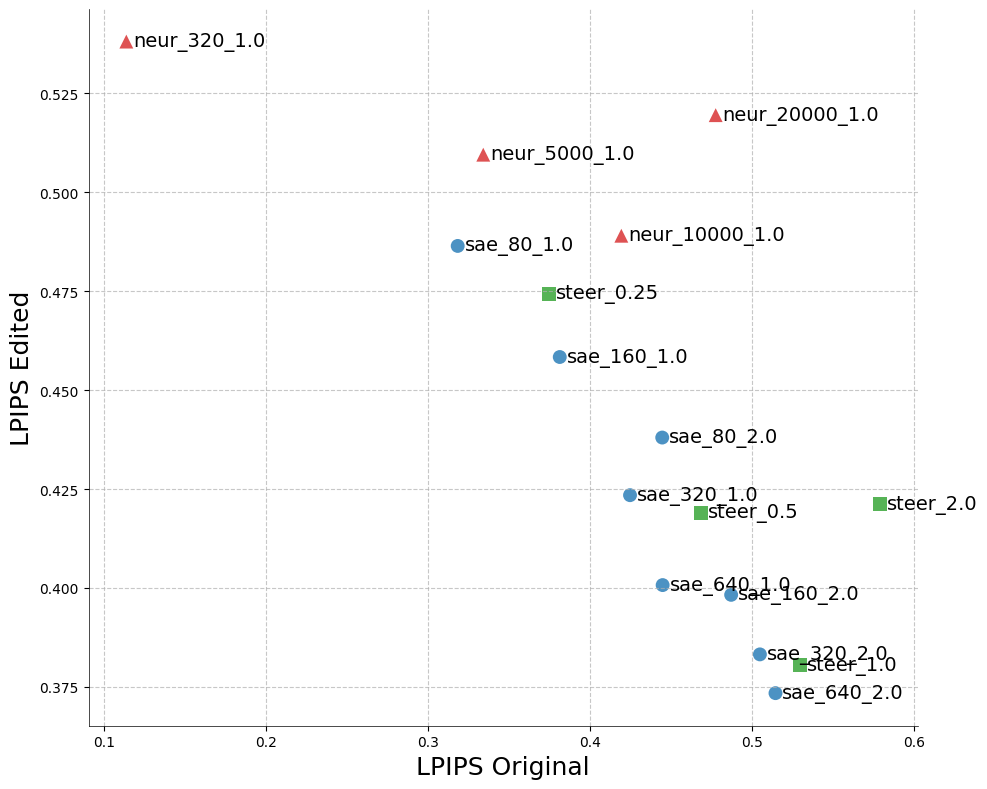

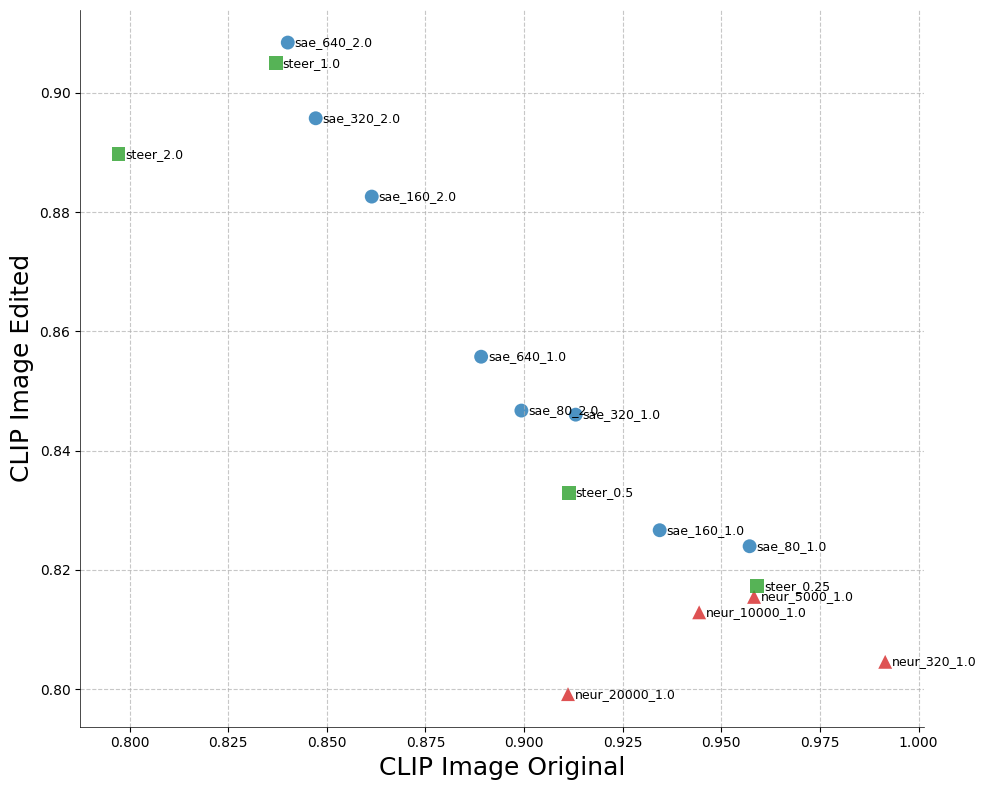

In [71]:
means = big_table.groupby("name")[["lpips_original", "lpips_edited", "clip_img_original", "clip_img_edited"]].mean()

# Define color schemes and markers based on method types
method_colors = {}
method_markers = {}

# Group similar methods with similar colors
for name in means.index:
    if 'sae' in name.lower():
        method_colors[name] = 'tab:blue'
        method_markers[name] = 'o'
    elif 'steer' in name.lower():
        method_colors[name] = 'tab:green'
        method_markers[name] = 's'
    elif 'neur' in name.lower():
        method_colors[name] = 'tab:red'
        method_markers[name] = '^'
    else:
        method_colors[name] = 'tab:purple'
        method_markers[name] = 'D'

# LPIPS plot with improved styling
fig, ax = plt.subplots(figsize=(10, 8))
for name, group in means.reset_index().groupby('name'):
    ax.scatter(group['lpips_original'], group['lpips_edited'], 
               color=method_colors.get(name, 'tab:gray'),
               marker=method_markers.get(name, 'o'),
               s=100, alpha=0.8, edgecolors='none')
    # Add text label next to the marker
    ax.annotate(name, 
                (group['lpips_original'].iloc[0], group['lpips_edited'].iloc[0]),
                xytext=(5, 0), 
                textcoords='offset points',
                fontsize=14,
                va='center')

# Add grid and improve styling
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.xlabel('LPIPS Original', fontsize=18)
plt.ylabel('LPIPS Edited', fontsize=18)
# Make x and y ticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# CLIP plot with improved styling
fig, ax = plt.subplots(figsize=(10, 8))
for name, group in means.reset_index().groupby('name'):
    ax.scatter(group['clip_img_original'], group['clip_img_edited'], 
               color=method_colors.get(name, 'tab:gray'),
               marker=method_markers.get(name, 'o'),
               s=100, alpha=0.8, edgecolors='none')
    # Add text label next to the marker
    ax.annotate(name, 
                (group['clip_img_original'].iloc[0], group['clip_img_edited'].iloc[0]),
                xytext=(5, 0), 
                textcoords='offset points',
                fontsize=14,
                va='center')

# Add grid and improve styling
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.xlabel('CLIP Image Original', fontsize=18)
plt.ylabel('CLIP Image Edited', fontsize=18)
# Make x and y ticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
